In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Neuromatch_project/ #change this to your google drive folder with weight


/content/drive/MyDrive/Neuromatch_project


In [3]:
!pip install pytorch-lightning wandb matplotlib scipy
!pip install torchvision tqdm
!pip install rsatoolbox==0.1.5 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 64.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import warnings
from pathlib import Path

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchmetrics import Accuracy
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Colab-specific settings
from torch import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass

warnings.filterwarnings("ignore", category=UserWarning)
os.environ['PYTHONWARNINGS'] = "ignore"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## load model and MNIST dataset

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Convolutional layers - same as your training model
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

    def forward_with_features(self, x, return_layers=None):
        """Forward pass that returns intermediate features"""
        if return_layers is None:
            return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']

        features = {}

        # Store input
        if 'input' in return_layers:
            features['input'] = x.clone()

        # Convolutional layers
        x = self.conv1(x)
        if 'conv1' in return_layers:
            features['conv1'] = x.clone()

        x = self.conv2(x)
        if 'conv2' in return_layers:
            features['conv2'] = x.clone()

        x = self.conv3(x)
        if 'conv3' in return_layers:
            features['conv3'] = x.clone()

        x = self.conv4(x)
        if 'conv4' in return_layers:
            features['conv4'] = x.clone()

        x = self.conv5(x)
        if 'conv5' in return_layers:
            features['conv5'] = x.clone()

        # Flatten
        x_flat = x.view(x.size(0), -1)
        if 'flatten' in return_layers:
            features['flatten'] = x_flat.clone()

        # Fully connected layers
        x = F.relu(self.fc1(x_flat))
        if 'fc1' in return_layers:
            features['fc1'] = x.clone()

        x = self.dropout(x)
        if 'fc1_dropout' in return_layers:
            features['fc1_dropout'] = x.clone()

        x = F.relu(self.fc2(x))
        if 'fc2' in return_layers:
            features['fc2'] = x.clone()

        x = self.dropout(x)
        if 'fc2_dropout' in return_layers:
            features['fc2_dropout'] = x.clone()

        x = self.fc3(x)
        if 'fc3' in return_layers or 'output' in return_layers:
            features['fc3'] = x.clone()
            features['output'] = x.clone()

        return x, features

model = AlexNet(num_classes=10)
model = model.to(device)



In [6]:
def load_mnist_dataset(batch_size=128, data_dir='/content/data'):
    """Load MNIST dataset with AlexNet-compatible transforms"""

    # Transform for AlexNet (resize to 227x227)
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
    ])

    # Load test dataset
    test_dataset = datasets.MNIST(
        root=data_dir,
        train=False,
        transform=transform,
        download=True
    )

    # Create data loader with appropriate num_workers for Colab
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Number of batches: {len(test_loader)}")
    print(f"Batch size: {batch_size}")

    return test_loader


print("Loading MNIST test dataset...")
test_loader = load_mnist_dataset()
print("Dataset loaded successfully!")

Loading MNIST test dataset...


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.78MB/s]

Test dataset size: 10000
Number of batches: 79
Batch size: 128
Dataset loaded successfully!


## load weight function

In [7]:
def check_checkpoint_file(checkpoint_path):
    """Check if checkpoint file exists and get its size"""
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    file_size = os.path.getsize(checkpoint_path) / (1024 * 1024)  # Size in MB
    print(f"Checkpoint file size: {file_size:.2f} MB")
    return True

def load_model_weights_colab(model, checkpoint_path, strict=True):
    """
    Load model weights optimized for Google Colab
    """

    print(f"Loading model from: {checkpoint_path}")

    # Check file first
    check_checkpoint_file(checkpoint_path)

    try:
        print("Loading checkpoint... (This may take a moment for large files)")

        # For Colab, try loading directly to GPU if available, otherwise CPU
        if torch.cuda.is_available():
            checkpoint = torch.load(checkpoint_path, map_location=device)
        else:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')

        print("Checkpoint loaded into memory successfully!")

        # Handle different checkpoint formats
        if isinstance(checkpoint, dict):
            print("Available keys in checkpoint:", list(checkpoint.keys()))

            if 'state_dict' in checkpoint:
                # PyTorch Lightning format
                state_dict = checkpoint['state_dict']
                print("✓ Detected PyTorch Lightning checkpoint format")

                # Print additional info if available
                if 'epoch' in checkpoint:
                    print(f"  Checkpoint epoch: {checkpoint['epoch']}")
                if 'global_step' in checkpoint:
                    print(f"  Global step: {checkpoint['global_step']}")

            elif 'model_state_dict' in checkpoint:
                # Standard PyTorch format
                state_dict = checkpoint['model_state_dict']
                print("✓ Detected standard PyTorch checkpoint format")
            else:
                # Direct state dict
                state_dict = checkpoint
                print("✓ Detected direct state dict format")
        else:
            # Direct state dict (older format)
            state_dict = checkpoint
            print("✓ Detected legacy state dict format")

        # Clean state dict keys
        cleaned_state_dict = {}
        for key, value in state_dict.items():
            # Remove common prefixes
            clean_key = key
            if key.startswith('module.'):
                clean_key = key[7:]  # Remove 'module.'
            elif key.startswith('model.'):
                clean_key = key[6:]  # Remove 'model.'

            cleaned_state_dict[clean_key] = value

        print(f"Found {len(cleaned_state_dict)} parameter tensors in checkpoint")

        # Load state dict
        print("Loading weights into model...")
        missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=strict)

        if missing_keys:
            print(f"⚠️  Missing keys: {missing_keys}")
        if unexpected_keys:
            print(f"⚠️  Unexpected keys: {unexpected_keys}")

        if not missing_keys and not unexpected_keys:
            print("✓ All model weights loaded perfectly!")
        else:
            print("✓ Model weights loaded with some mismatches (this might be normal)")

        # Move model to device if not already there
        model = model.to(device)
        print(f"✓ Model moved to {device}")

    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        if strict:
            print("🔄 Retrying with strict=False...")
            return load_model_weights_colab(model, checkpoint_path, strict=False)
        else:
            raise e

    return model

def load_model_safe_colab(checkpoint_path, num_classes=10):
    """
    Safe model loading with proper error handling for Colab
    """
    try:
        # Create fresh model instance
        print("Creating fresh model instance...")
        model = AlexNet(num_classes=num_classes)

        # Load weights
        print("Loading model weights...")
        model = load_model_weights_colab(model, checkpoint_path)

        # Set to evaluation mode
        model.eval()
        print("✓ Model set to evaluation mode")

        return model

    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

# List available checkpoint files in the current directory
print("Available checkpoint files:")
checkpoint_files = [f for f in os.listdir('.') if f.endswith(('.ckpt', '.pt', '.pth'))]
for i, file in enumerate(checkpoint_files):
    size_mb = os.path.getsize(file) / (1024*1024)
    print(f"  {i+1}. {file} ({size_mb:.1f} MB)")

if not checkpoint_files:
    print("  No checkpoint files found in current directory")
    print("  Make sure you're in the right directory and files are uploaded")

Available checkpoint files:
  1. model-0-ckpt.ckpt (667.2 MB)


## weight loaded

In [8]:
MODEL_PATH = "model-0-ckpt.ckpt"
model = load_model_weights_colab(model, MODEL_PATH)

Loading model from: model-0-ckpt.ckpt
Checkpoint file size: 667.20 MB
Loading checkpoint... (This may take a moment for large files)
Checkpoint loaded into memory successfully!
Available keys in checkpoint: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters']
✓ Detected PyTorch Lightning checkpoint format
  Checkpoint epoch: 8
  Global step: 4221
Found 16 parameter tensors in checkpoint
Loading weights into model...
✓ All model weights loaded perfectly!
✓ Model moved to cuda


## Test the accuracy on test dataset

In [9]:
def test_model_clean(model, test_loader):
    """Test model on clean (no noise) MNIST data"""

    print("Testing model on clean data...")
    model.eval()
    correct = 0
    total = 0

    # Progress tracking
    total_batches = len(test_loader)
    print_interval = max(1, total_batches // 10)  # Print progress 10 times

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print progress
            if (batch_idx + 1) % print_interval == 0:
                current_acc = correct / total
                print(f"  Progress: {batch_idx + 1}/{total_batches} batches, "
                      f"Current accuracy: {current_acc*100:.2f}%")

    accuracy = correct / total
    print(f'✓ Clean Test Accuracy: {accuracy*100:.2f}%')
    return accuracy

In [10]:
clean_accuracy = test_model_clean(model, test_loader)

Testing model on clean data...
  Progress: 7/79 batches, Current accuracy: 98.66%
  Progress: 14/79 batches, Current accuracy: 98.83%
  Progress: 21/79 batches, Current accuracy: 98.55%
  Progress: 28/79 batches, Current accuracy: 98.63%
  Progress: 35/79 batches, Current accuracy: 98.66%
  Progress: 42/79 batches, Current accuracy: 98.68%
  Progress: 49/79 batches, Current accuracy: 98.84%
  Progress: 56/79 batches, Current accuracy: 98.94%
  Progress: 63/79 batches, Current accuracy: 99.03%
  Progress: 70/79 batches, Current accuracy: 99.10%
  Progress: 77/79 batches, Current accuracy: 99.11%
✓ Clean Test Accuracy: 99.11%


## Feature extractor

In [11]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

In [12]:
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

## Function from W1D3

In [35]:
def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    if return_layers == 'all':
        return_layers, _ = get_graph_node_names(model)
    elif return_layers == 'layers':
        layers, _ = get_graph_node_names(model)
        return_layers = [l for l in layers if 'input' in l or 'conv' in l or 'fc' in l]

    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    return model_features

def get_sample_images_ordered(test_loader, n_samples=100, samples_per_class=None):


    # For MNIST, we have 10 classes (0-9)
    num_classes = 10

    # Calculate samples per class
    if samples_per_class is None:
        samples_per_class = n_samples // num_classes

    # Adjust total samples to ensure even distribution
    actual_n_samples = samples_per_class * num_classes

    print(f"Collecting {samples_per_class} samples per class ({actual_n_samples} total)")

    # Collect images by class
    class_images = {i: [] for i in range(num_classes)}
    class_labels = {i: [] for i in range(num_classes)}

    # Collect images from dataloader
    for batch_imgs, batch_labels in test_loader:
        for img, label in zip(batch_imgs, batch_labels):
            label_int = label.item()

            # Only collect if we haven't reached the limit for this class
            if len(class_images[label_int]) < samples_per_class:
                class_images[label_int].append(img.unsqueeze(0))
                class_labels[label_int].append(label.unsqueeze(0))

        # Check if we have enough samples for all classes
        if all(len(class_images[i]) >= samples_per_class for i in range(num_classes)):
            break


    ordered_imgs = []
    ordered_labels = []

    for class_idx in range(num_classes):
        # Take exactly samples_per_class for each class
        class_imgs = class_images[class_idx][:samples_per_class]
        class_lbls = class_labels[class_idx][:samples_per_class]

        ordered_imgs.extend(class_imgs)
        ordered_labels.extend(class_lbls)


    final_imgs = torch.cat(ordered_imgs)
    final_labels = torch.cat(ordered_labels)


    return final_imgs, final_labels

def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]


        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def plot_rdms(rdms_dict, figsize_per_plot=(4, 3), cmap='viridis'):
    """
    Plot RDMs for visualization

    Args:
        rdms_dict: Dictionary of RDMs by layer name
        figsize_per_plot: Size of each subplot
        cmap: Colormap for visualization
    """

    n_layers = len(rdms_dict)
    cols = min(3, n_layers)  # Max 3 columns
    rows = (n_layers + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols,
                            figsize=(cols * figsize_per_plot[0], rows * figsize_per_plot[1]))

    if n_layers == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()

    for idx, (layer_name, rdm) in enumerate(rdms_dict.items()):
        ax = axes[idx]

        # Plot RDM
        im = ax.imshow(rdm, cmap=cmap, aspect='auto')
        ax.set_title(f'{layer_name}\n({rdm.shape[0]}×{rdm.shape[1]})')
        ax.set_xlabel('Stimulus')
        ax.set_ylabel('Stimulus')

        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)

    # Hide empty subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Representational Dissimilarity Matrices (RDMs)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()


## RDM

In [14]:
train_nodes, eval_nodes = get_graph_node_names(AlexNet())
train_nodes

['x',
 'conv1.0',
 'conv1.1',
 'conv1.2',
 'conv2.0',
 'conv2.1',
 'conv2.2',
 'conv3.0',
 'conv3.1',
 'conv4.0',
 'conv4.1',
 'conv5.0',
 'conv5.1',
 'conv5.2',
 'size',
 'view',
 'fc1',
 'relu',
 'dropout',
 'fc2',
 'relu_1',
 'dropout_1',
 'fc3']

In [36]:
return_layers = [
    'x',
 'conv1.0',
 'conv1.1',
 'conv1.2',
 'conv2.0',
 'conv2.1',
 'conv2.2',
 'conv3.0',
 'conv3.1',
 'conv4.0',
 'conv4.1',
 'conv5.0',
 'conv5.1',
 'conv5.2',
  'fc1',
  'fc2',
  'fc3'] ## get from train nodes

imgs, labels =  get_sample_images_ordered(test_loader, samples_per_class=15) # extract 15 images from each category, totally 150 images
model_features = extract_features(model, imgs.to(device), return_layers=return_layers)


In [28]:
rdms, rdms_dict = calc_rdms(model_features)

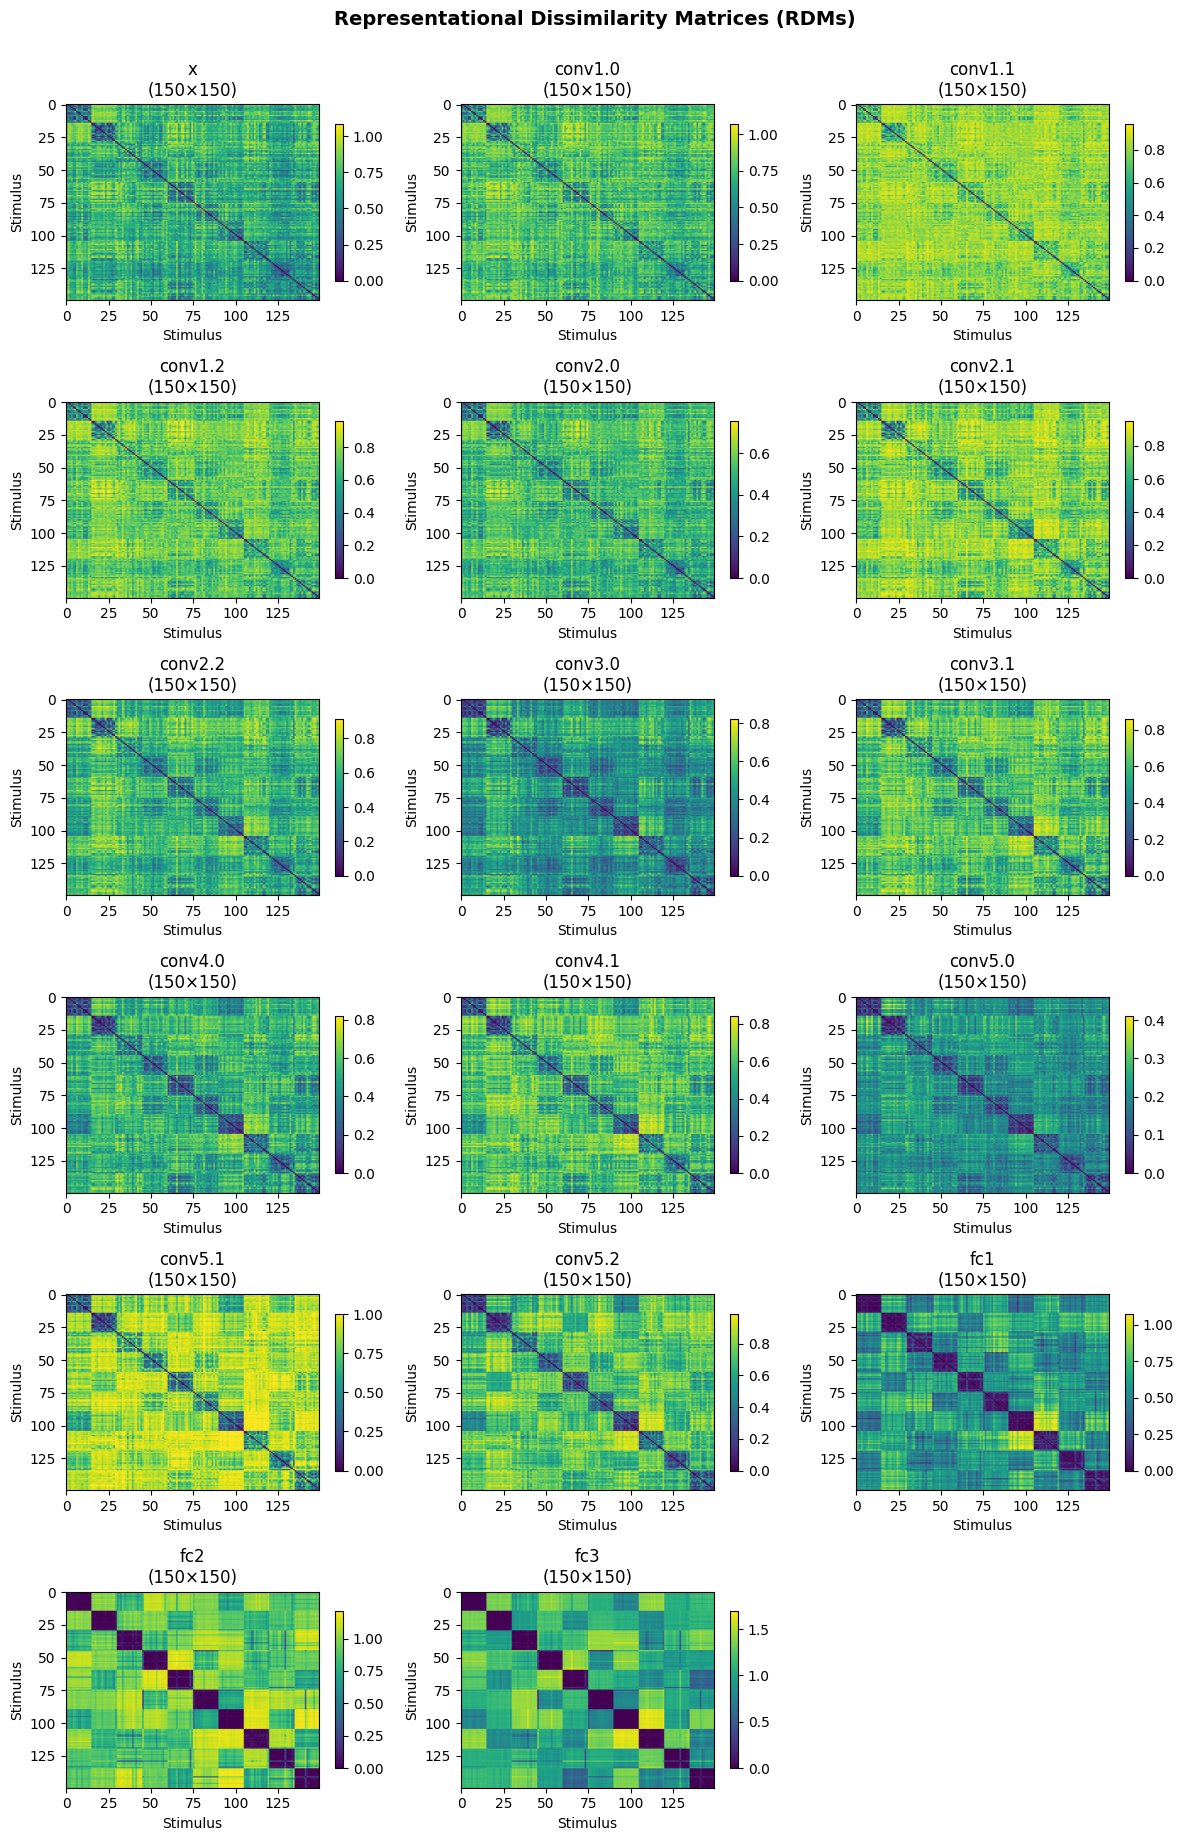

In [30]:
plot_rdms(rdms_dict)